In [1]:
import torch
import os
import torch.nn.functional as F
from torch import Tensor
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm, trange

In [95]:
path = "../../data/"
data = pd.read_csv(path + 'train_events.csv')
video = pd.read_csv(path + 'video_info_v2.csv')
targets = pd.read_csv(path + 'train_targets.csv')

# Big model embeds

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

def sbs(strings, size=30, space=4):
    strings = list(strings)
    result = []

    while any(strings):
        line = []

        for i, s in enumerate(strings):
            if s is None:
                s = ""
            buf = s[:size]
            
            try:
                n = buf.index("\n")
                line.append(buf[:n].ljust(size))
                strings[i] = s[n+1:]
            except ValueError:
                line.append(buf.ljust(size))
                strings[i] = s[size:]

        result.append((" " * space).join(line))
    
    return "\n".join(result)

# device = "cuda:4"

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')

device_ids = [3]
model = nn.DataParallel(model, device_ids=device_ids)
n_gpu = len(device_ids)

model.to(f"cuda:{device_ids[0]}")
model.device_ids


max_length = 512
def tokenize(texts):
    tensors = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors="pt")
    return {k : v for k, v in tensors.items()}

def embed(texts):
    with torch.no_grad():
        t = tokenize(texts)
        
        last_state = model(**t).last_hidden_state
        return last_token_pool(last_state, t["attention_mask"])

def embed_batched(texts, bs=512):
    n = len(texts)
    res = []
    for i in trange(0, n, bs):
        res.append(embed(texts[i:i+bs]))
    return list(torch.cat(res).cpu().numpy().squeeze())

KeyboardInterrupt: 

In [10]:
embeds = embed_batched(list(video['title']))

100%|██████████| 3762/3762 [17:39<00:00,  3.55it/s]


In [ ]:
from sklearn.decomposition import PCA

def reduce_dimensionality(data, target_dimension=32):
    """
    Уменьшает размерность данных с d до target_dimension с помощью PCA.

    Args:
        data (numpy.ndarray): Исходные данные размерности (n_samples, d).
        target_dimension (int): Желаемая размерность выходных данных. По умолчанию 32.

    Returns:
        numpy.ndarray: Данные размерности (n_samples, target_dimension).
    """
    # Инициализируем PCA с целевой размерностью
    pca = PCA(n_components=target_dimension)
    
    # Применяем PCA к данным
    reduced_data = pca.fit_transform(data)
    
    return reduced_data

embeds_32 = reduce_dimensionality(embeds, target_dimension=256)

In [88]:
#np.save('data/embeds_32.npy', embeds_32)
embeds_32 = np.load('data/embeds_32.npy')

In [45]:
#np.save('data/embeds.npy', embeds)
embeds = np.load('data/embeds.npy')

# Normalize

In [96]:
video['text'] = video.apply(lambda x: x['title'] + f' Категория: {x['category']}', axis=1)
video['duration_sec'] = video['duration'] // 1000
#video['embeds'] = list(embeds)
video['embeds_32'] = list(embeds_32)
targets['sex'] = targets['sex'].apply(lambda x: 0 if x == 'male' else 1)
data = data.merge(video, on='rutube_video_id', how='inner')
data = data.merge(targets, on='viewer_uid', how='inner')
data['count'] = data.groupby('viewer_uid')['viewer_uid'].transform('count')
data['part_wached'] = data['total_watchtime'] / data['duration_sec']
data = data.sort_values(by='event_timestamp')

# TF-IDF

In [5]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pymystem3
tqdm.pandas()

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
stemmer = pymystem3.Mystem()


def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление ненужных символов
    text = re.sub(r'[^a-zа-яё0-9\s]', '', text)
    text = ''.join(stemmer.lemmatize(text))
    return text


data['cleaned_text'] = data['text'].progress_apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/kuzakov-
[nltk_data]     dn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1759616/1759616 [07:26<00:00, 3940.89it/s]


In [6]:
# Создание tf-idf векторов
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords, min_df=0.001, max_df=0.1)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_text'])
data['tf_idf_embeds'] = list(tfidf_matrix)

In [7]:
tfidf_vectorizer.get_feature_names_out()

array(['01062024', '02062024', '03062024', '04062024', '05062024',
       '06062024', '10', '100', '10062024', '11', '11062024', '12', '13',
       '13062024', '14', '14062024', '15', '16', '17', '17062024', '18',
       '18062024', '19', '19062024', '1999', '20', '2001', '2002', '2003',
       '2004', '2005', '2006', '20062024', '2007', '20072019', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
       '21', '21062024', '22', '23', '24', '24062024', '25', '25062024',
       '26', '26062024', '27', '27062024', '28', '28052024', '28062024',
       '29', '29052024', '30', '30052024', '31052024', '333', '41', '45',
       '56', '57', '58', '59', '911', 'and', 'bad', 'bang', 'better',
       'big', 'bones', 'boys', 'break', 'breaking', 'bridgerton', 'call',
       'castle', 'classrooms', 'club', 'comedy', 'dark', 'de', 'diaries',
       'doctor', 'fallout', 'files', 'friends', 'good', 'jas

# Sum embeds

In [8]:
# Усредняем с коэффициентами
def custom_aggregation(df):
    coeffs = np.array(df['part_wached'])
    coeffs /= np.linalg.norm(coeffs)
    return np.sum([coef * vec for vec, coef in zip(df['embeds'], coeffs)], axis=0)

def custom_aggregation_tf_idf(df):
    coeffs = np.array(df['part_wached'])
    coeffs /= np.linalg.norm(coeffs)
    return np.sum([coef * vec for vec, coef in zip(df['tf_idf_embeds'], coeffs)], axis=0)


def no_aggregation(df):
    return np.array(df['embeds'])

print('tf_idf')
users_embeds_tf_idf = data.groupby('viewer_uid').apply(custom_aggregation_tf_idf)
#print('embeds')
#users_embeds = data.groupby('viewer_uid').apply(custom_aggregation)

#users_embeds.name = 'embed'
users_embeds_tf_idf.name = 'embed_tf_idf'

#targets = pd.merge(users_embeds, targets, on='viewer_uid', how='inner')
targets = pd.merge(users_embeds_tf_idf, targets, on='viewer_uid', how='inner')

tf_idf


/var/tmp/ipykernel_404066/141634748.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  users_embeds_tf_idf = data.groupby('viewer_uid').apply(custom_aggregation_tf_idf)


# Models

In [112]:
from sklearn.model_selection import train_test_split


train_ids, test_ids = train_test_split(targets['viewer_uid'], test_size=0.3, random_state=42)

X_train = data[data.viewer_uid.isin(train_ids)]
X_train = X_train.groupby('viewer_uid').agg(
    texts=('text', lambda x: '; '.join(x))
)
y_train = data[data.viewer_uid.isin(train_ids)]['age_class']
X_test = data[data.viewer_uid.isin(test_ids)]
X_test = X_test.groupby('viewer_uid').agg(
    texts=('text', lambda x: '; '.join(x))
)
y_test = data[data.viewer_uid.isin(test_ids)]['age_class']

In [119]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch


model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)

def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=400)

X_train_tokenised = [tokenize_function(text) for text in X_train['texts']]
X_test_tokenised = [tokenize_function(text) for text in X_test['texts']]

/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
X_train_tokenised

[{'input_ids': [101, 42525, 102773, 21979, 570, 18705, 29672, 21731, 28680, 117, 10233, 22140, 117, 128, 61884, 519, 12378, 69417, 20110, 131, 39968, 53370, 47970, 10987, 14208, 132, 42525, 102773, 21979, 570, 18705, 29672, 21731, 28680, 117, 10233, 22140, 117, 129, 61884, 519, 12378, 69417, 20110, 131, 39968, 53370, 47970, 10987, 14208, 132, 42525, 102773, 21979, 570, 18705, 29672, 21731, 28680, 117, 10233, 22140, 117, 130, 61884, 519, 12378, 69417, 20110, 131, 39968, 53370, 47970, 10987, 14208, 132, 42525, 102773, 21979, 570, 18705, 29672, 21731, 28680, 117, 10233, 22140, 117, 10150, 61884, 519, 12378, 69417, 20110, 131, 39968, 53370, 47970, 10987, 14208, 132, 42525, 102773, 21979, 570, 18705, 29672, 21731, 28680, 117, 10233, 22140, 117, 10193, 61884, 519, 12378, 69417, 20110, 131, 39968, 53370, 47970, 10987, 14208, 132, 538, 18705, 29672, 21731, 12095, 119, 525, 17759, 10267, 11148, 117, 122, 22140, 117, 122, 61884, 519, 12378, 69417, 20110, 131, 39968, 53370, 47970, 10987, 14208, 1

In [ ]:
X_train_tokenised

# simple nets

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report
import scipy

## Reverse подход: по 1 видео предсказание возраста, а затем усреднение

In [101]:
train_ids, test_ids = train_test_split(targets['viewer_uid'], test_size=0.3, random_state=42)

X_train = np.stack(data[data.viewer_uid.isin(train_ids)]['embeds_32'])
#X_train = np.squeeze(np.stack([i.toarray() for i in X_train]))
y_train = data[data.viewer_uid.isin(train_ids)]['age_class']
X_test = np.stack(data[data.viewer_uid.isin(test_ids)]['embeds_32'])
#X_test = np.squeeze(np.stack([i.toarray() for i in X_test]))
y_test = data[data.viewer_uid.isin(test_ids)]['age_class']

In [102]:
log_reg_age = LogisticRegression(max_iter=1000)
log_reg_age.fit(X_train, y_train)
y_pred_age = log_reg_age.predict(X_test)

In [103]:
print("Classification report for age prediction:")
print(classification_report(y_test, y_pred_age))

Classification report for age prediction:


/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     20263
           1       0.44      0.52      0.47    195035
           2       0.40      0.52      0.45    202920
           3       0.47      0.16      0.24    109220

    accuracy                           0.42    527438
   macro avg       0.33      0.30      0.29    527438
weighted avg       0.41      0.42      0.40    527438



/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [109]:
data_predict = data[data['viewer_uid'].isin(test_ids)]
data_predict['preds_one'] = log_reg_age.predict(np.stack(data_predict['embeds_32']))
preds_all = data_predict.groupby('viewer_uid').agg(
    preds_all=('preds_one', lambda x: x.value_counts().idxmax())
)
preds_all = preds_all.merge(targets[['viewer_uid', 'age_class']], on='viewer_uid')

/var/tmp/ipykernel_404066/3140947341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_predict['preds_one'] = log_reg_age.predict(np.stack(data_predict['embeds_32']))


In [110]:
print("Classification report for age prediction:")
print(classification_report(preds_all['age_class'], preds_all['preds_all']))

Classification report for age prediction:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2280
           1       0.43      0.44      0.44     18967
           2       0.39      0.58      0.46     19692
           3       0.47      0.19      0.27     13065

    accuracy                           0.41     54004
   macro avg       0.32      0.30      0.29     54004
weighted avg       0.41      0.41      0.39     54004



/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuzakov-dn/miniconda3/envs/other_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## linear

In [9]:
# Создание признаков и целевых переменных
#X = np.concatenate((np.squeeze(np.stack([i.toarray() for i in targets['embed_tf_idf']])), np.stack(targets['embed'])), axis=1)
X = np.squeeze(np.stack([i.toarray() for i in targets['embed_tf_idf']]))
y = targets[['viewer_uid', 'sex', 'age_class', 'age']]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [37]:
# Логистическая регрессия для предсказания пола
log_reg_gender = LogisticRegression(max_iter=1000)
log_reg_gender.fit(X_train, y_train['sex'])
y_pred_gender = log_reg_gender.predict(X_test)

print("Classification report for gender prediction:")
print(classification_report(y_test['sex'], y_pred_gender))

# Логистическая регрессия для предсказания возраста
log_reg_age = LogisticRegression(max_iter=1000)
log_reg_age.fit(X_train, y_train['age_class'])
y_pred_age = log_reg_age.predict(X_test)

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

KeyboardInterrupt: 

# catboost

In [41]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [42]:
from catboost import CatBoostClassifier


# CatBoost для предсказания пола
catboost_gender = CatBoostClassifier(iterations=1000, verbose=150)
catboost_gender.fit(X_train, y_train['sex'], eval_set=(X_val, y_val['sex']))
y_pred_gender = catboost_gender.predict(X_test)

print("Classification report for gender prediction:")
print(classification_report(y_test['sex'], y_pred_gender))

# CatBoost для предсказания возрастной категории
catboost_age = CatBoostClassifier(iterations=1000, verbose=150)
catboost_age.fit(X_train, y_train['age_class'], eval_set=(X_val, y_val['age_class']))
y_pred_age = catboost_age.predict(X_test)

print("Classification report for age prediction:")
print(classification_report(y_test['age_class'], y_pred_age))

CatBoostError: Length of weight=4 and length of data=108007 are different.

# sequential

## age

Epoch [1/10], Loss: 1.1852, Val F1: 0.4403
Epoch [2/10], Loss: 1.1165, Val F1: 0.4482
Epoch [3/10], Loss: 1.1069, Val F1: 0.4455
Epoch [4/10], Loss: 1.1010, Val F1: 0.4492
Epoch [5/10], Loss: 1.0961, Val F1: 0.4432
Epoch [6/10], Loss: 1.0909, Val F1: 0.4517
Epoch [7/10], Loss: 1.0862, Val F1: 0.4492
Epoch [8/10], Loss: 1.0813, Val F1: 0.4508
Epoch [9/10], Loss: 1.0764, Val F1: 0.4531
Epoch [10/10], Loss: 1.0717, Val F1: 0.4537


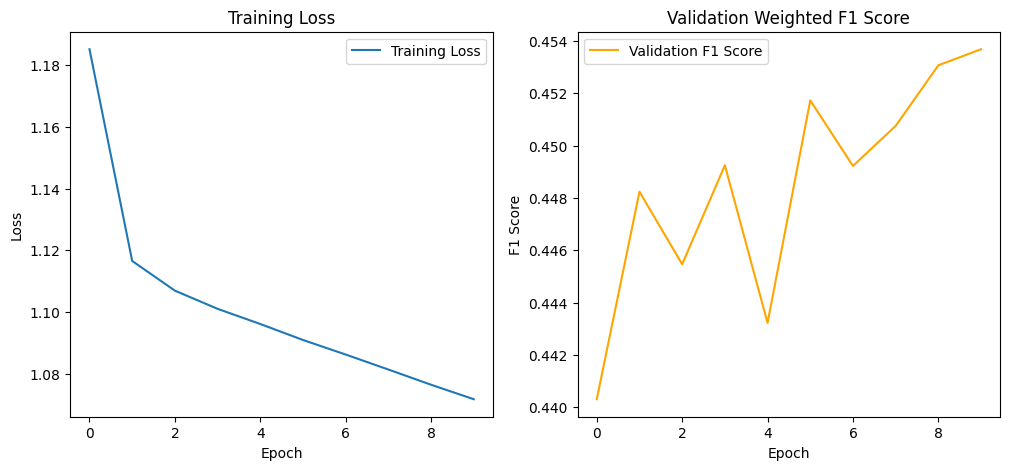

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Устройство (GPU если доступно)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Датасеты и их загрузчики
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(np.array(y_train['age_class']), dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(np.array(y_test['age_class']), dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Определение модели
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 250
num_classes = 4
num_epochs = 10
learning_rate = 0.001

model = SimpleNN(input_size, hidden_size, num_classes).to(device)

# Определение критерия и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_f1_scores = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Валидация модели
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_f1_scores.append(val_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

# Построение графиков
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation Weighted F1 Score')
plt.legend()

plt.show()

## sex


Epoch [1/10], Loss: 3480.5214, Val accuracy: 0.7384
Epoch [2/10], Loss: 3458.1756, Val accuracy: 0.7416
Epoch [3/10], Loss: 3456.4972, Val accuracy: 0.7426
Epoch [4/10], Loss: 3455.9031, Val accuracy: 0.7409
Epoch [5/10], Loss: 3455.5394, Val accuracy: 0.7416
Epoch [6/10], Loss: 3455.2175, Val accuracy: 0.7428
Epoch [7/10], Loss: 3454.9251, Val accuracy: 0.7408
Epoch [8/10], Loss: 3454.6948, Val accuracy: 0.7422
Epoch [9/10], Loss: 3454.5268, Val accuracy: 0.7429
Epoch [10/10], Loss: 3454.4412, Val accuracy: 0.7421


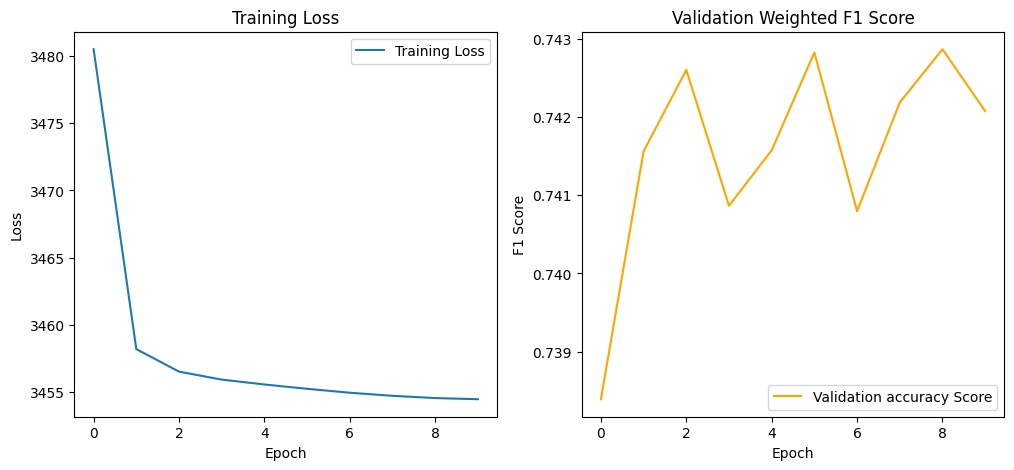

In [14]:
import torch.nn.functional as F

# Устройство (GPU если доступно)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Датасеты и их загрузчики
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(np.array(y_train['sex']), dtype=torch.float))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(np.array(y_test['sex']), dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Определение модели
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 250
num_epochs = 10
learning_rate = 0.001

model = SimpleNN(input_size, hidden_size).to(device)

# Определение критерия и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_f1_scores = []

# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Прямой проход
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        # Обнуление градиентов
        optimizer.zero_grad()
        
        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Валидация модели
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_f1 = accuracy_score(all_labels, all_preds)
    val_f1_scores.append(val_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val accuracy: {val_f1:.4f}")

# Построение графиков
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation accuracy Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.title('Validation Weighted accuracy Score')
plt.legend()

plt.show()

# Analysis

In [16]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.26      0.01      0.01      2992
           1       0.49      0.55      0.52     25032
           2       0.42      0.46      0.44     26458
           3       0.49      0.42      0.45     17523

    accuracy                           0.46     72005
   macro avg       0.42      0.36      0.36     72005
weighted avg       0.46      0.46      0.45     72005



In [17]:
all_preds[:10], all_labels[:10]

([2, 3, 2, 2, 1, 1, 2, 2, 3, 1], [1, 2, 2, 2, 1, 1, 1, 2, 3, 2])

In [18]:
y_test['preds'] = all_preds

In [19]:
y_test = data.groupby('viewer_uid').agg(
    count=('viewer_uid', 'count')
).reset_index().merge(y_test, on='viewer_uid', how='inner')

In [20]:
y_test.head()

viewer_uid  count  sex  age_class  age  preds
0    10000001     19    1          2   40      1
1    10000006      1    0          2   38      2
2    10000014      1    0          3   43      2
3    10000016      1    0          2   31      2
4    10000025      1    0          2   32      3

In [24]:
cnt = 10
print(classification_report(y_test[y_test['count'] > cnt]['age_class'], y_test[y_test['count'] > cnt]['preds']))

              precision    recall  f1-score   support

           0       0.23      0.02      0.04       701
           1       0.51      0.61      0.55      6657
           2       0.45      0.53      0.48      7032
           3       0.56      0.30      0.39      3976

    accuracy                           0.49     18366
   macro avg       0.44      0.36      0.37     18366
weighted avg       0.49      0.49      0.47     18366



In [41]:
y_test[(np.abs(y_test.age_class - y_test.preds) > 1) & (y_test.age_class == 0) & (y_test['count'] > 10)]

viewer_uid  count  sex  age_class  age  preds
2492     10010481     22    1          0   19      2
3773     10014475     28    1          0   11      2
4441     10016572     32    1          0   20      2
4619     10017186     19    1          0   20      2
5669     10020529     31    0          0   20      2
...           ...    ...  ...        ...  ...    ...
70746    11080157     31    1          0   14      2
70853    11081231     67    0          0   18      2
70879    11083341     14    1          0   12      2
70924    11088585     35    0          0   18      2
70957    11090474     25    1          0   19      2

[183 rows x 6 columns]

In [42]:
uid = 10010481
print(targets[targets.viewer_uid == uid]['age_class'].iloc[0])
print()
for idx, text in enumerate(data[data.viewer_uid == uid]['text']):
    print(idx, text)

0

0 Титаны, 1 выпуск Категория: Телепередачи
1 Титаны, 2 выпуск Категория: Телепередачи
2 Титаны, 1 выпуск Категория: Телепередачи
3 Титаны, 2 выпуск Категория: Телепередачи
4 Выжить в Дубае. Возвращение, 1 выпуск Категория: Телепередачи
5 Новая Битва экстрасенсов, 24 сезон, 14 выпуск. ФИНАЛ Категория: Телепередачи
6 Титаны, 5 выпуск Категория: Телепередачи
7 Выжить в Дубае. Возвращение, 2 выпуск Категория: Телепередачи
8 Выжить в Дубае, 1 выпуск Категория: Телепередачи
9 Выжить в Дубае, 2 выпуск Категория: Телепередачи
10 Выжить в Дубае, 3 выпуск Категория: Телепередачи
11 Выжить в Дубае, 4 выпуск Категория: Телепередачи
12 Выжить в Дубае, 5 выпуск Категория: Телепередачи
13 Выжить в Дубае, 6 выпуск Категория: Телепередачи
14 Выжить в Дубае, 7 выпуск Категория: Телепередачи
15 Выжить в Дубае, 8 выпуск Категория: Телепередачи
16 Выжить в Дубае, 9 выпуск Категория: Телепередачи
17 Выжить в Дубае, 10 выпуск Категория: Телепередачи
18 Выжить в Дубае, 11 выпуск Категория: Телепередачи
19 

In [43]:
targets[targets.viewer_uid == uid]

viewer_uid                                       embed_tf_idf  age  sex  \
6236    10010481  <Compressed Sparse Row sparse matrix of dtype ...   19    1   

      age_class  
6236          0

In [44]:
sparse_row = targets.loc[6236]['embed_tf_idf']
nonzero_indices = sparse_row.nonzero()[1]
tfidf_values = sparse_row.data
terms = tfidf_vectorizer.get_feature_names_out()

# Печатаем термы и их TF-IDF значения
for idx, value in zip(nonzero_indices, tfidf_values):
    print(f"Терм: {terms[idx]}, TF-IDF значение: {value}")

Терм: 12, TF-IDF значение: 0.10611568970023388
Терм: 10, TF-IDF значение: 0.10653972607474144
Терм: 14, TF-IDF значение: 0.12578405649022845
Терм: финал, TF-IDF значение: 0.23025902624270023
Терм: 24, TF-IDF значение: 0.09503234295760375
Терм: экстрасенс, TF-IDF значение: 0.08886954398274725
Терм: битва, TF-IDF значение: 0.0891599691572334
Терм: новый, TF-IDF значение: 0.0876005988768835
Терм: титан, TF-IDF значение: 1.182505462430009
Терм: выживать, TF-IDF значение: 1.9070662548015733
Терм: дубай, TF-IDF значение: 1.9745821851570509
Терм: возвращение, TF-IDF значение: 0.4523202135528529
Терм: 11, TF-IDF значение: 0.11229264011811688


In [36]:
cnt = 0
uids = set()
for idx, (text, viewer_uid) in tqdm(data[['text', 'viewer_uid']].iterrows(), total=data.shape[0]):
    if 'менталист' in text.lower():
        uids.add(viewer_uid)
        cnt += 1
print(cnt, cnt / video.shape[0])

100%|██████████| 1759616/1759616 [00:56<00:00, 31223.95it/s]

5284 0.010974495306139403


In [37]:
list(uids)[:10]

[10455041,
 10087428,
 10073096,
 10677258,
 10067985,
 10965522,
 10071571,
 10045972,
 10198036,
 10624534]